## This notebook selects the XXX best contours and saves their data as indvidiual watershed csv
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.HDBSCAN.html

In [1]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [5]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd

import matplotlib.colors as mcolors

from sklearn.preprocessing import MinMaxScaler
import hdbscan

In [3]:
# import undrogued data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

In [10]:
# Set the random seed
random_seed = 42
np.random.seed(random_seed)

In [11]:
# get features for clustering and normalize to close to scale of lat/lon with lat/lon weighted for clustering AND RUN HDBSCAN TWICE
# get beach points for beach lat/lon
last_points_input = beach.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 30, # minimum number beach points in a cluster
    cluster_selection_epsilon = 6) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

#organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 100:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), beach_clusters_select.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(beach_clusters_select['id'])]

In [12]:
# NOW INPUT CLUSTERED DATA INTO NEW HDBSCAN
# get beach points for beach lat/lon
last_points_input = beach_clusters.drop_duplicates(subset='id', keep='last')

# input feature: beach latitude
beach_lat = np.array(last_points_input['lat']).reshape(-1,1)

# input feature: beach longitude
beach_lon = np.array(last_points_input['lon']).reshape(-1,1)

# initialize input
cluster_input = np.column_stack((beach_lat, beach_lon))#, time_normalized, v_avg_normalized))

hdb = hdbscan.HDBSCAN(
    min_cluster_size = 10, # minimum number beach points in a cluster
    cluster_selection_epsilon = 5) # clusters below distance threshold are merged
hdb.fit(cluster_input)
labels = hdb.labels_

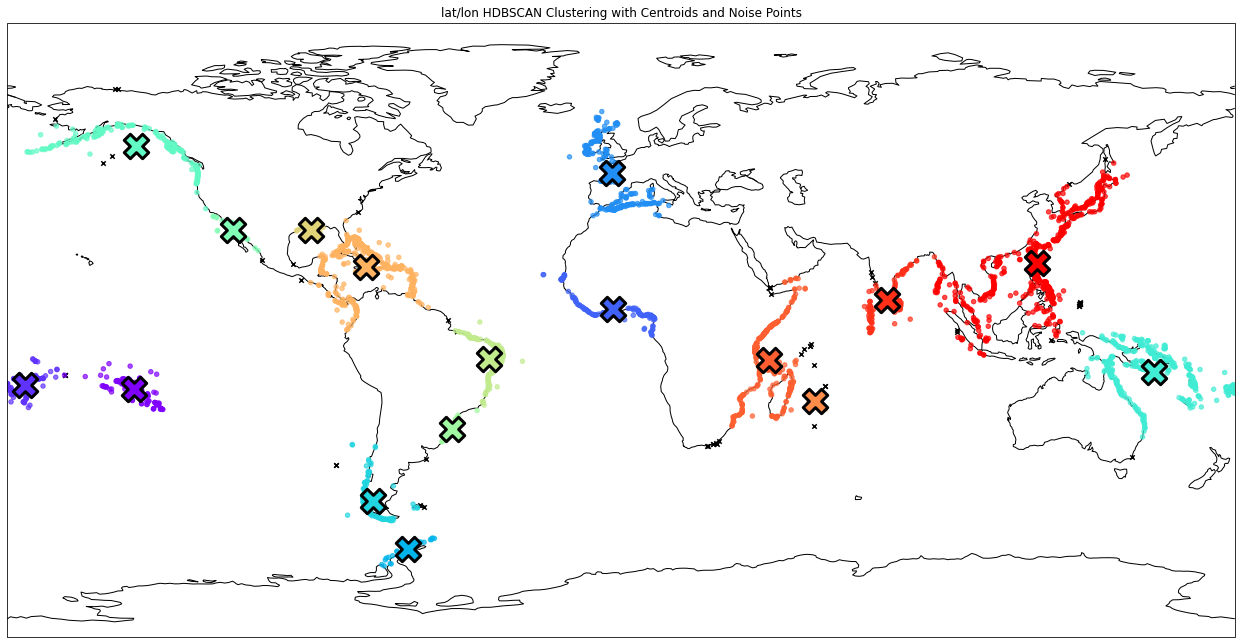

In [13]:
fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
#left right bottom top
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
point_size = 10

# Plot noise points as small 'x'
noise_mask = (labels == -1)
ax.scatter(cluster_input[noise_mask, 1], cluster_input[noise_mask, 0], marker='x', color='black', s=20, label='Noise Points')

# Scatter plot with colors based on HDBSCAN labels
scatter1 = plt.scatter(
    cluster_input[labels != -1, 1],
    cluster_input[labels != -1, 0],
    marker='o',
    c=labels[labels != -1],
    cmap='rainbow',
    alpha=0.7,
    s=20
)

# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id != -1:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')

# Get the colors used in the first figure
colors_first_figure = scatter1.to_rgba(scatter1.get_array())

#ax.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('lat/lon HDBSCAN Clustering with Centroids and Noise Points')
plt.show()

In [14]:
unique_labels_figure1 = np.unique(cluster_df['HDBSCAN'])

# organize dataframe of ids and HDBSCAN cluster labels
cluster_df = pd.DataFrame({'id': last_points_input['id'], 'HDBSCAN': labels})

histogram = plt.hist(cluster_df['HDBSCAN'], bins = len(np.unique(cluster_df['HDBSCAN'])))
plt.close() # do not display histogram
cluster_ids = []
count = np.min(cluster_df['HDBSCAN'])
for i in histogram[0]:
    if i > 0:
        cluster_ids.append(count)
    count += 1
    
# remove unclustered 'noise' and select clusters
cluster_ids = cluster_ids[1:]
beach_clusters_select = cluster_df[cluster_df['HDBSCAN'].isin(cluster_ids)]

# resample without replacement
num_trajectories = round(len(beach_clusters_select)/2)
resampled_df = beach_clusters_select.sample(n=num_trajectories, replace=False, random_state=42)
resampled_df.reset_index(drop=True, inplace=True)


# merge cluster labels with the original data

beach_clusters = pd.merge(beach.set_index('id'), resampled_df.set_index('id'), left_index=True, right_index=True, how='left').reset_index()
beach_clusters = beach_clusters[beach_clusters['id'].isin(resampled_df['id'])]

# Create a colormap with distinct colors for each cluster label
colors_custom_cmap = plt.cm.get_cmap('rainbow', len(unique_labels_figure1))

# Create a dictionary to map each cluster label to its corresponding color
cluster_color_mapping = dict(zip(unique_labels_figure1, range(len(unique_labels_figure1))))

# Apply the mapping to the HDBSCAN labels in the beach_clusters DataFrame
beach_clusters['Color'] = beach_clusters['HDBSCAN'].map(cluster_color_mapping)

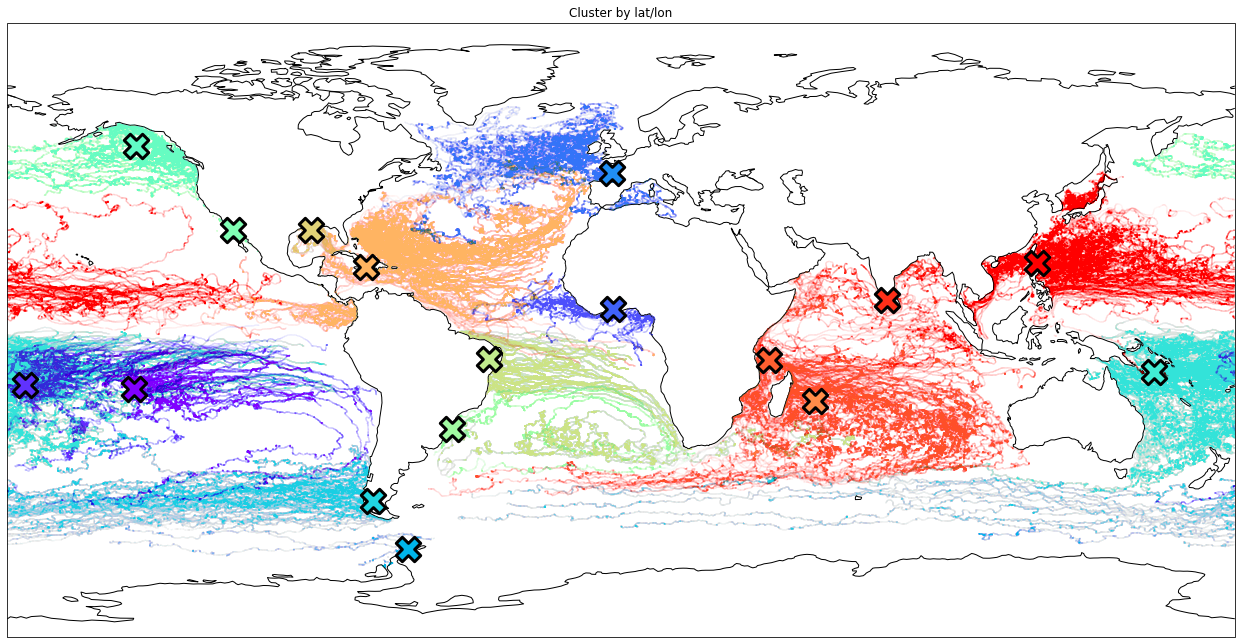

In [15]:
# Plotting code for next fig

point_size = 0.00005

fig = plt.figure(figsize=(22, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()

# Scatter plot with colors based on the custom colormap
scatter2 = plt.scatter(
    beach_clusters['lon'],
    beach_clusters['lat'],
    marker='o',
    c=beach_clusters['Color'],
    cmap=colors_custom_cmap,
    s=point_size,
    alpha=0.7
)


# Plot centroids with the same colors as corresponding points
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id in np.unique(beach_clusters['HDBSCAN']):
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')


# Add colorbar
#cbar = plt.colorbar(scatter2, orientation='vertical', pad=0.02, ticks=unique_labels_figure2)
#cbar.set_label('HDBSCAN Cluster', fontsize=16)
#cbar.ax.tick_params(labelsize=14)

plt.title('Cluster by lat/lon')

plt.show()

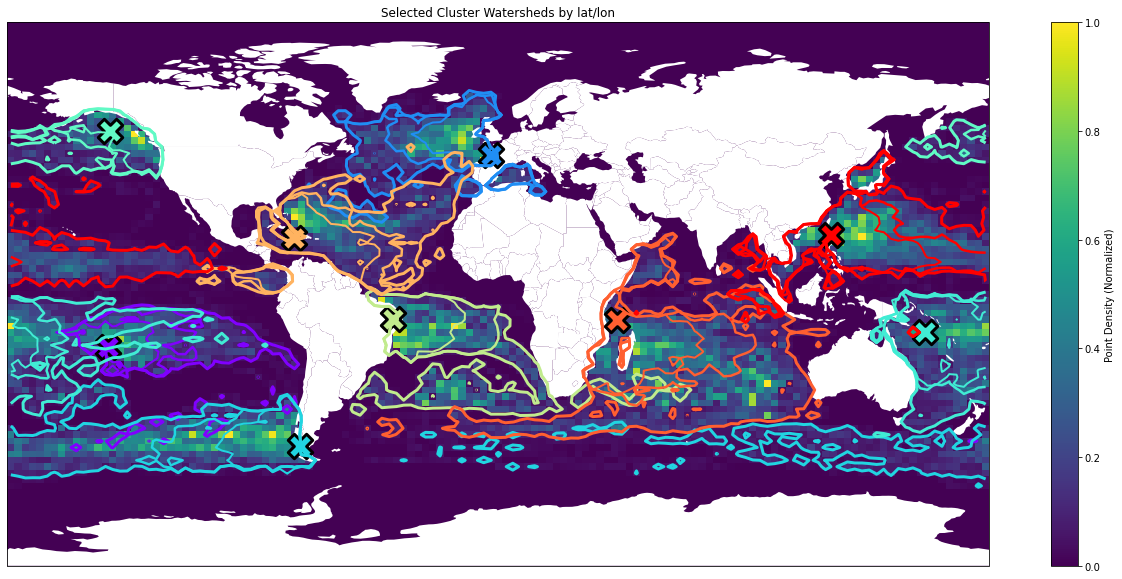

In [35]:
cluster_outputs = []
for i in np.unique(beach_clusters['HDBSCAN']):
    cluster_outputs.append(beach_clusters[beach_clusters['HDBSCAN'] == i])

selected_clusters = [cluster_outputs[i] for i in [0, 3, 5, 6, 7, 10, 12, 14, 16]]
selected_cluster_ids = [0, 3, 5, 6, 7, 10, 12, 14, 16]

fig = plt.figure(figsize=(22, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']

cmap = plt.cm.get_cmap("viridis").copy()
#cmap.set_bad('grey')



###full
# Define the grid for the heatmap
n_lons, n_lats = 135, 85  # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# initialize mesh
heatmap_data_normalized = np.zeros((n_lats, n_lons))

# initalize color count to get outside contour colors to match above figures
color_count = 0
for cluster in selected_clusters:
    
    latitudes = []
    longitudes = []
    latitudes12 = []
    longitudes12 = []
    latitudes6 = []
    longitudes6 = []
    latitudes3 = []
    longitudes3 = []
    latitudes1 = []
    longitudes1 = []

    for ID in np.unique(cluster['id']):
        trajectory = cluster[cluster['id'] == ID]

        latest_time = max(trajectory['time'])
        start_time = latest_time - 15552000000000 # Full
        start_time12 = latest_time - 31536000 # 12m
        start_time6 = latest_time - 15552000 # 6m
        start_time3 = latest_time - 7890000 # 3m
        start_time1 = latest_time - 2629800 # 1m

        latest_data_all = trajectory[trajectory['time'] <= latest_time]

        latest_data = latest_data_all[latest_data_all['time'] >= start_time]
        latest_data12 = latest_data_all[latest_data_all['time'] >= start_time12]
        latest_data6 = latest_data_all[latest_data_all['time'] >= start_time6]
        latest_data3 = latest_data_all[latest_data_all['time'] >= start_time3]
        latest_data1 = latest_data_all[latest_data_all['time'] >= start_time1]

        latitudes += list(latest_data['lat'])
        longitudes += list(latest_data['lon'])

        latitudes12 += list(latest_data12['lat'])
        longitudes12 += list(latest_data12['lon'])

        latitudes6 += list(latest_data6['lat'])
        longitudes6 += list(latest_data6['lon'])

        latitudes3 += list(latest_data3['lat'])
        longitudes3 += list(latest_data3['lon'])

        latitudes1 += list(latest_data1['lat'])
        longitudes1 += list(latest_data1['lon'])




    # Calculate the 2D histogram (density plot) of point density
    heatmap_data, _, _ = np.histogram2d(latitudes, longitudes, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized_cluster = (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    lon_centers_cluster = (lon_bins[1:] + lon_bins[:-1]) / 2
    lat_centers_cluster = (lat_bins[1:] + lat_bins[:-1]) / 2
    
    # append to previous clusters
    heatmap_data_normalized += (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data))

    
    ###12

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data12, _, _ = np.histogram2d(latitudes12, longitudes12, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized12 = (heatmap_data12 - np.min(heatmap_data12)) / (np.max(heatmap_data12) - np.min(heatmap_data12))

    ###6

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data6, _, _ = np.histogram2d(latitudes6, longitudes6, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized6 = (heatmap_data6 - np.min(heatmap_data6)) / (np.max(heatmap_data6) - np.min(heatmap_data6))

    ###3

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data3, _, _ = np.histogram2d(latitudes3, longitudes3, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized3 = (heatmap_data3 - np.min(heatmap_data3)) / (np.max(heatmap_data3) - np.min(heatmap_data3))


    ###1

    # Calculate the 2D histogram (density plot) of point density
    heatmap_data1, _, _ = np.histogram2d(latitudes1, longitudes1, bins=[lat_bins, lon_bins], density=True)

    # Normalize the data to be in the range [0, 1]
    heatmap_data_normalized1 = (heatmap_data1 - np.min(heatmap_data1)) / (np.max(heatmap_data1) - np.min(heatmap_data1))


    # Repeat the process for other plots with increasing linewidth
    linewidths = [3, 2.5, 2]
    outside_colors = scatter1.to_rgba(selected_cluster_ids[color_count])
    colors = [outside_colors, 'white', 'white']
    
    for data_normalized, linewidth in zip([heatmap_data_normalized_cluster, heatmap_data_normalized6, heatmap_data_normalized3], linewidths):
        # Add contour lines at the specified level (0.05 in this case)
        contour = plt.contour(lon_centers_cluster, lat_centers_cluster, data_normalized, levels=[0.05], colors=colors, linestyles='solid', linewidths=linewidth, transform=ccrs.PlateCarree())
    
    #update color count
    color_count += 1
    
    
# Plot the filled contour for normalized heatmap
mesh = ax.pcolormesh(lon_centers_cluster, lat_centers_cluster, heatmap_data_normalized, cmap=cmap, transform=ccrs.PlateCarree())

# Plot the land polygons with white face color, no edge
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')


# Plot centroids with the same colors as corresponding clusters
for cluster_id in set(labels):
    cluster_mask = (labels == cluster_id)

    if cluster_id in selected_cluster_ids:
        cluster_points = cluster_input[cluster_mask]
        centroid = np.mean(cluster_points, axis=0)
        color = scatter1.to_rgba(cluster_id)  # Get the color from the first scatter plot
        ax.scatter(centroid[1], centroid[0], marker='X', color=color, edgecolor='black', linewidths=3, s=600, label=f'Cluster {cluster_id} Centroid')


plt.colorbar(mesh, label='Point Density (Normalized)')
ax.set_aspect('auto')
plt.title('Selected Cluster Watersheds by lat/lon')

plt.show()

In [41]:
beach_clusters

,id,time,lat,lon,ve,vn,time_to_beach,HDBSCAN,Color
1111,2931,966556800,-16.92552,117.61980,0.0280,-0.2189,36432000.0,14.0,15
1112,2931,966560400,-16.92813,117.62168,0.0543,-0.0925,36428400.0,14.0,15
1113,2931,966564000,-16.93054,117.62340,0.0532,-0.0925,36424800.0,14.0,15
1114,2931,966567600,-16.93310,117.62496,0.0516,-0.0930,36421200.0,14.0,15
1115,2931,966571200,-16.93573,117.62629,0.0493,-0.0940,36417600.0,14.0,15
...,...,...,...,...,...,...,...,...,...
23068316,300534061493020,1479099600,-25.56162,32.84329,-0.0229,0.0856,14400.0,14.0,15
23068317,300534061493020,1479103200,-25.55574,32.84336,-0.0152,0.1357,10800.0,14.0,15
23068318,300534061493020,1479106800,-25.54986,32.84343,-0.0075,0.1857,7200.0,14.0,15
23068319,300534061493020,1479110400,-25.54366,32.84254,-0.0166,0.1889,3600.0,14.0,15


In [52]:
# initialize dataframe list
cluster_dataframes = []

# for making new directory
os.makedirs('selected_clusters', exist_ok=True)

# iterate through each of the selected_cluster_ids
for cluster_id in selected_cluster_ids:
    # Filter rows in beach_clusters for the current cluster ID
    cluster_data = beach_clusters[beach_clusters['HDBSCAN'] == cluster_id].drop(columns=['Color'])
    
    # make list of dataframes
    cluster_dataframes.append(cluster_data)
    
    # save to file
    file = f"cluster_{cluster_id}_data.csv"
    cluster_data.to_csv('selected_clusters/' + file, index=False)